In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [104]:
import numpy as np 
import os
import tensorflow as tf
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import Sequential
from tensorflow.keras import layers

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.compat.v1.disable_eager_execution()

from keras.utils.np_utils import to_categorical
from keras import metrics
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.metrics import Recall
from keras.metrics import Precision
from tensorflow.keras.utils import plot_model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50


import cv2
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.utils import shuffle 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


import math
import random


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [105]:
class_names = ["damaged_infrastructure", "damaged_nature", "fires", "flood", "human_damage", "non_damage"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
num_classes = len(class_names)

## Test to check that our classes are correct for classifcation:
print(num_classes)
print(class_names)

IMAGE_SIZE = (150,150)

6
['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']


In [106]:
def load_data():
    
    #datasets = ["C:/Users/dodi/Desktop/NEURAL PROJECT/TRAIN_DATA150x150" , "C:/Users/dodi/Desktop/NEURAL PROJECT/TEST_DATA150x150"]
    datasets = ["/content/drive/MyDrive/Neural Project/TRAIN_DATA150x150" , "/content/drive/MyDrive/Neural Project/TEST_DATA150x150"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [107]:
## Function to plot the accuracy loss as a response to the history: 

def plot_accuracy_loss(history):
  fig = plt.figure(figsize = (30, 15) )


  plt.subplot(221)
  plt.plot(history.history["Accuracy"], "bo--", label = "Accuracy")
  plt.plot(history.history["Val_Accuracy"], "ro--", label = "Val_Accuracy")
  plt.title("Train Accuracy vs, Val Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(222)
  plt.plot(history.history["Loss"], "bo--", label = "Loss")
  plt.plot(history.history["Val_Loss"], "ro--", label = "Val_Loss")
  plt.title("Train Loss vs, Val Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

In [108]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image # : '.format(index) + class_names[labels[index]])
    plt.show()

  
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [109]:
def generate_actual_predicted(model, X_test, Y_test):
    # Get the predictions
    Y_pred = model.predict(X_test)

    # Create a list of predictions

    #Converting predictions to label
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))

    #Converting one hot encoded test label back to label
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))

    return actual, predicted

In [110]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [111]:
(train_images, train_labels), (test_images, test_labels)  = load_data()
print("Done")

  6%|▌         | 25/422 [00:00<00:01, 245.54it/s]

Loading /content/drive/MyDrive/Neural Project/TRAIN_DATA150x150


  0%|          | 0/103 [00:00<?, ?it/s]

Loading /content/drive/MyDrive/Neural Project/TEST_DATA150x150


100%|██████████| 69/69 [00:00<00:00, 269.84it/s]


Done


In [112]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4715
Number of testing examples: 1174
Each image is of size: (150, 150)


In [113]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

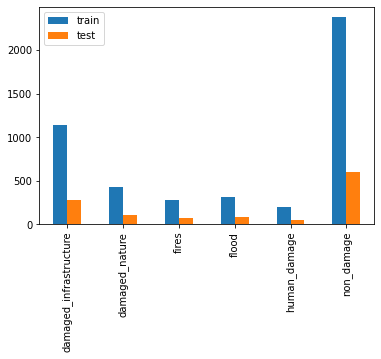

In [114]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [115]:
total_damage = 0

print("Classes 0 through 4: ")
for i in range(len(train_counts)-1):
    total_damage += train_counts[i]
    print(train_counts[i])

print("------------")
print("Sum classes 0 through 4: ")
print(total_damage)
print("------------")

total_non_damage = train_counts[-1]
print("Class 5: ")
print(total_non_damage)

r_05 = train_counts[0] / train_counts[5] * 100
r_15 = train_counts[1] / train_counts[5] * 100
r_25 = train_counts[2] / train_counts[5] * 100
r_35 = train_counts[3] / train_counts[5] * 100
r_45 = train_counts[4] / train_counts[5] * 100

print("Ratio of class 0 to class 5: ", r_05)
print("Ratio of class 1 to class 5: ", r_15)
print("Ratio of class 2 to class 5: ", r_25)
print("Ratio of class 3 to class 5: ", r_35)
print("Ratio of class 4 to class 5: ", r_45)

Classes 0 through 4: 
1135
422
280
308
192
------------
Sum classes 0 through 4: 
2337
------------
Class 5: 
2378
Ratio of class 0 to class 5:  47.72918418839361
Ratio of class 1 to class 5:  17.74600504625736
Ratio of class 2 to class 5:  11.774600504625736
Ratio of class 3 to class 5:  12.95206055508831
Ratio of class 4 to class 5:  8.074011774600505


In [116]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

batch_size=128
width = 150

### train_steps_per_epoch=math.ceil(train_images.samples/batch_size)
### valid_steps_per_epoch=math.ceil(valid_data.samples/batch_size)
### test_steps_per_epoch=math.ceil(test_data.samples/batch_size)

In [117]:
print(train_labels)
print(class_names_label)

[1 0 5 ... 5 5 1]
{'damaged_infrastructure': 0, 'damaged_nature': 1, 'fires': 2, 'flood': 3, 'human_damage': 4, 'non_damage': 5}


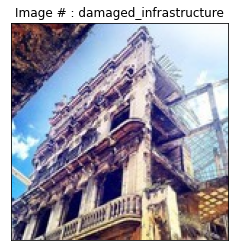

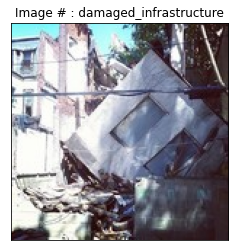

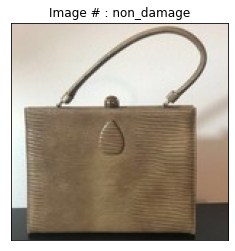

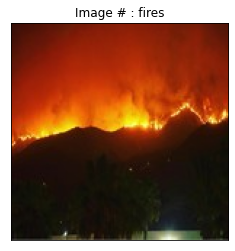

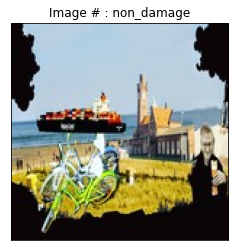

In [118]:
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)

In [119]:
#class_weight = {0: r_05,
#                1: r_15,
#                2: r_25,
#                3: r_35,
#                4: r_45,
#                5: 1.,
#               }

#train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)
#train_labels = np.argmax(train_images, axis=1)
#print(train_labels)
#print(test_labels)

#class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
#d_class_weights = dict(enumerate(class_weights))

#train_labels = np.array(train_labels)
#print(train_labels)
#print(train_labels.shape)

#class_weights = class_weight.compute_class_weight('balanced',
#                                                np.unique(np.array(train_labels)),
#                                                 np.array(train_labels))
#
#print(class_weights)


#print(train_labels)
#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)


#print(train_labels)
#print(train_labels.shape)

class_weights = {0:0.69236417, 1:1.8621643  , 2:2.80654762 , 3:2.55140693 , 4:4.09288194  , 5:0.33045977 }
print(class_weights)


{0: 0.69236417, 1: 1.8621643, 2: 2.80654762, 3: 2.55140693, 4: 4.09288194, 5: 0.33045977}


In [120]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [121]:
#print(train_labels)


print(train_labels)
print(train_labels.shape)
print(test_labels)
print(test_labels.shape)


#train_labels = np.argmax(train_labels, axis = 1)
#print(train_labels)
#test_labels = np.argmax(test_labels, axis = 1)
#print(test_labels)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
(4715, 6)
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(1174, 6)


In [122]:
#------------------------------#

#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units = 512, activation = 'relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(units = 128, activation = 'relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(units = 6, activation = 'softmax'),
#]) 


#------------------------------#
#model = tf.keras.Sequential([
#    
#    
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
    

#    tf.keras.layers.Dropout(0.4),
   
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])

#------------------------------# This one is decent but not the best
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])
#------------------------------#
#------------------------------#
#------------------------------#
#------------------------------# BEST SO FAR
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])

#------------------------------#
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPooling2D(2,2),

    #model.add(layers.ZeroPadding2D( padding = 1 )),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
])
#------------------------------# 


#------------------------------#
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),

#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    #tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    #tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
    
#    tf.keras.layers.ZeroPadding2D( padding = (1,1)),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.6),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])
#------------------------------# 

#model = ResNet50(weights='imagenet', include_top=False)
#train_features = model.predict(train_images)
#test_features = model.predict(test_images)


#------------------------------#
#model = VGG16(weights = 'imagenet', include_top = False, input_shape= (150,150, 3), classes = 6, classifier_activation="softmax")
#------------------------------#


#------------------------------#

#model = tf.keras.Sequential()
#model.add(Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=6, activation="softmax")) 



#------------------------------#


#model = tf.keras.Sequential()

#model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
#model.add(layers.ZeroPadding2D( padding = 1 ))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

#model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
#model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
#model.add(layers.ZeroPadding2D( padding = 1 ))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation=tf.nn.relu))

#model.add(layers.Dropout(0.5))

#model.add(layers.Dense(6, activation=tf.nn.softmax))



#------------------------------#

model.summary()



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 15, 15, 256)     

In [123]:
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])

#model.summary()

In [124]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',
                        metrics.AUC(name='auc'),
                        metrics.Precision(name='precision'),
                        metrics.Recall(name='recall'),
                        ])


#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [125]:
num_epochs = 40
history = model.fit(train_images, train_labels, batch_size=128, epochs= num_epochs, validation_split = 0.33,class_weight=class_weights)

Train on 3159 samples, validate on 1556 samples
Epoch 1/40
3159/3159 [==============================] - ETA: 0s - loss: 1.7889 - accuracy: 0.2900 - auc: 0.6224 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3159/3159 [==============================] - 4s 1ms/sample - loss: 1.7889 - accuracy: 0.2900 - auc: 0.6224 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7817 - val_accuracy: 0.4229 - val_auc: 0.7153 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
3159/3159 [==============================] - 3s 896us/sample - loss: 1.7284 - accuracy: 0.2225 - auc: 0.6170 - precision: 0.3579 - recall: 0.0108 - val_loss: 1.7158 - val_accuracy: 0.4370 - val_auc: 0.7426 - val_precision: 0.3140 - val_recall: 0.0174
Epoch 3/40
3159/3159 [==============================] - 3s 893us/sample - loss: 1.6656 - accuracy: 0.2675 - auc: 0.6492 - precision: 0.4674 - recall: 0.0272 - val_loss: 1.7011 - val_accuracy: 0.3644 - val_auc: 0.7384 - val_precision: 0.4058 - val_recall: 0.0540
Epoch 4/40
3159/3159 [==============================] - 3s 891us/sample - loss: 1.6547 - accuracy: 0.2517 - auc: 0.6387 - precision: 0.4908 - recall: 0.0339 - val_loss: 1.6734 - val_accuracy: 0.1272 - val_auc: 0

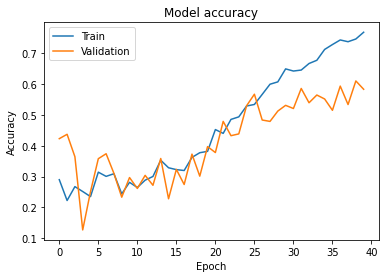

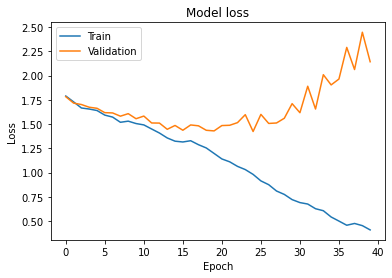

In [126]:
## Plotting the accuracy over time. 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss over time
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

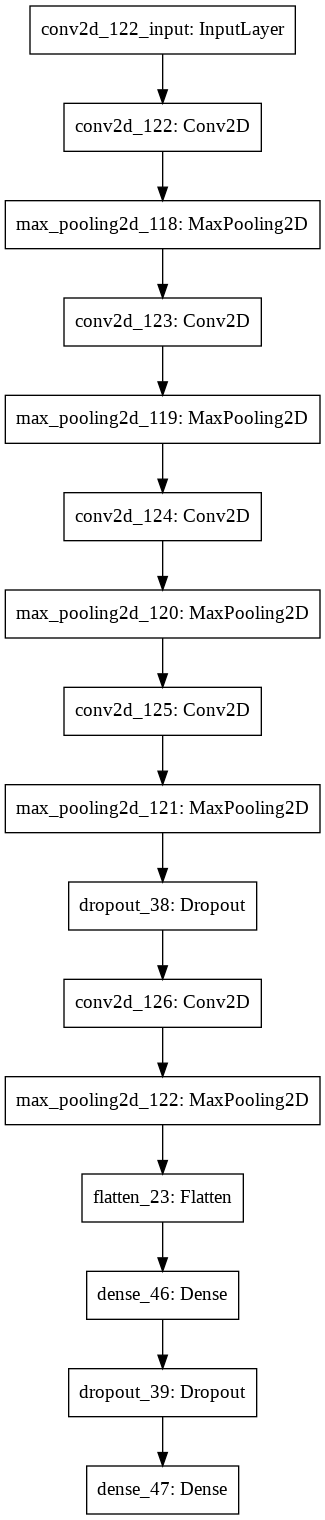

In [127]:

plot_model(model)

In [128]:
print("Number of images in our test_data: ")
print(test_labels.shape[0])
print(test_images.shape[0])
#train_labels = np.argmax(train_labels, axis = 1)
print(train_labels)
#test_labels = np.argmax(test_labels, axis = 1)
print(test_labels)

Number of images in our test_data: 
1174
1174
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [129]:
#test_labels = to_categorical(test_labels)
#print(test_labels)


score = model.evaluate(test_images, test_labels)
#score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Test loss: 1.381569125380183
Test accuracy: 0.560477


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


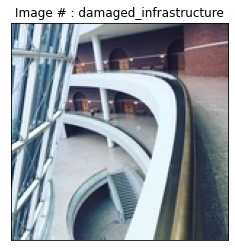

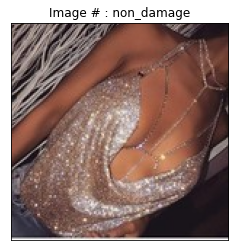

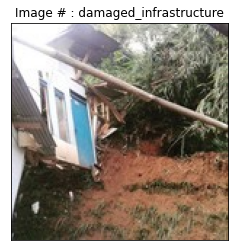

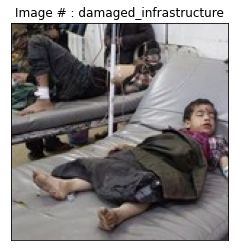

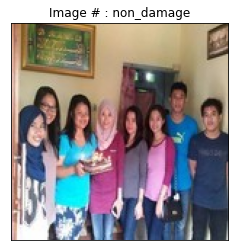

In [130]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
actual, predicted = generate_actual_predicted(model, test_images, test_labels)

display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


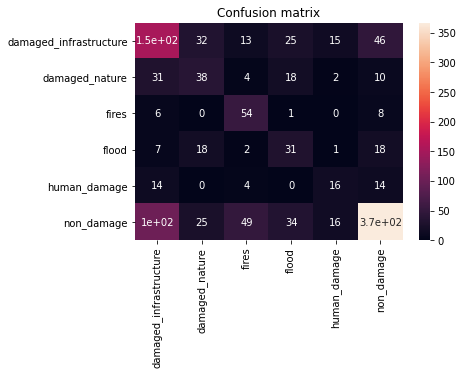

In [131]:
print(train_labels)
train_labels = np.argmax(train_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sb.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

,AUC
0,0.753689
1,0.806641
2,0.926408
3,0.805858
4,0.762674
5,0.792932


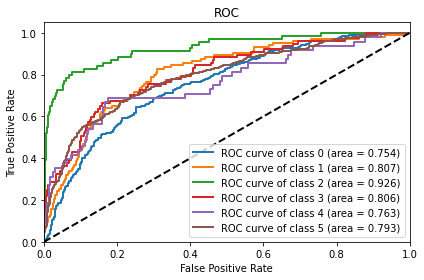

In [132]:
y = to_categorical(test_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.shape[1]  

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

In [133]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.49      0.54      0.51       283
           1       0.34      0.37      0.35       103
           2       0.43      0.78      0.55        69
           3       0.28      0.40      0.33        77
           4       0.32      0.33      0.33        48
           5       0.79      0.62      0.69       594

    accuracy                           0.56      1174
   macro avg       0.44      0.51      0.46      1174
weighted avg       0.60      0.56      0.57      1174



In [134]:
#report = classification_report(test_labels, pred_labels, output_dict=True)
#df = pd.DataFrame(report).transpose()

#plt.ylabel('Precision')
#plt.xlabel('Recall')
#x = df["precision"][:6]
#y = df["recall"][:6]

#plt.scatter(x, y)
#plt.legend()
#plt.show()

#plt.plot(history.history['precision'],history.history['recall'],'o', color='black',label='precision vs. recall')
#plt.plot(history.history['recall'],history.history['val_recall'],'o', color='red',label='val_precision vs. val_recall')
#plt.title('Model Precision and Recall')

#plt.legend()
#plt.show()


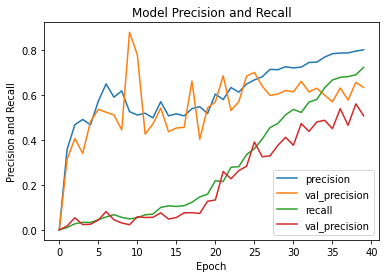

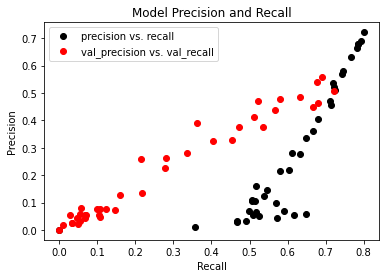

In [135]:
plt.plot(history.history['precision'],label='precision')
plt.plot(history.history['val_precision'],label='val_precision')
plt.plot(history.history['recall'],label='recall')
plt.plot(history.history['val_recall'],label='val_precision')
plt.title('Model Precision and Recall')
plt.ylabel('Precision and Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validate'], loc='upper left')
#plt.show()

#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validate'], loc='upper left')
#plt.show()


plt.plot(history.history['precision'],history.history['recall'],'o', color='black',label='precision vs. recall')
plt.plot(history.history['recall'],history.history['val_recall'],'o', color='red',label='val_precision vs. val_recall')
plt.title('Model Precision and Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

In [136]:
def create_model():
#  model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.MaxPooling2D(2,2),
#    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.6),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])



  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPooling2D(2,2),

    #model.add(layers.ZeroPadding2D( padding = 1 )),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
])

  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',
                        metrics.AUC(name='auc'),
                        metrics.Precision(name='precision'),
                        metrics.Recall(name='recall'),
                        ])
    
  return model
    
    
    
    


In [137]:
#print(train_labels)
#train_labels = to_categorical(train_labels)
print(train_labels)
print(train_labels.shape)

[1 0 5 ... 5 5 1]
(4715,)


In [138]:
n_split=10
#zero_division = 0

 
# We will split the the data n_split times
# and create and for the model with the said
# parameters


results = list()
for train_index,test_index in KFold(n_split).split(train_images): 
  print(train_index + 1)
  # use the index to generate training an testing sets
  x_train,x_test=train_images[train_index],train_images[test_index]
  y_train,y_test=train_labels[train_index],train_labels[test_index]
  
  # create and fit the model
  model=create_model()
  #model.fit(x_train, y_train,epochs=2)
  model.fit(x_train, y_train, epochs= 2, class_weight=class_weights)
  
  # print and show generic metrics available
  scores = model.evaluate(x_test,y_test)
 
  # print the model metrics
  for i,names in zip(np.arange(0,len(model.metrics_names)),model.metrics_names):
      print(model.metrics_names[i],'=',scores[i])
  # calculate and print more metrics
  actual, predicted = generate_actual_predicted(model, x_test, y_test)
  print("precision ",precision_score(actual, predicted, average='macro'))
  print("recall ", recall_score(actual, predicted, average='macro'))
  print("F1-Score ", f1_score(actual, predicted, average='macro'))
  results.append([precision_score(actual, predicted, average='macro'),
                  recall_score(actual, predicted, average='macro'), 
                  f1_score(actual, predicted, average='macro') ])

[ 473  474  475 ... 4713 4714 4715]


ValueError: ignored

[0.44861819 0.47029938 0.40837506 0.4299326  0.46773569 0.43140193
 0.4425389  0.44974896 0.41735071 0.49580553]
[0.46932085 0.48301143 0.48388589 0.45965335 0.46329631 0.4639477
 0.49741064 0.39150608 0.47071059 0.44864416]


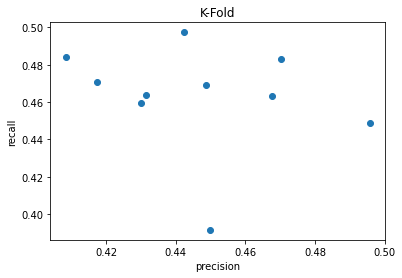

min precision: 0.40837505944117347
min recall: 0.3915060843003257
max precision: 0.49580553451825904
max recall: 0.4974106428208666
average precision: 0.4461806960716676 sd= 0.025067382656600946
average recall: 0.463138701552788 sd= 0.02729402947213789


In [43]:
# Plot the curves for precision
res = np.array(results)
#print(res)

prec = res[:,0]
print(prec)
recl = res[:,1]
print(recl)

import matplotlib.pyplot as plt
plt.scatter(prec, recl)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('K-Fold') 
plt.show()

print('min precision:', prec.min())
print('min recall:', recl.min())
print('max precision:', prec.max())
print('max recall:', recl.max())
print('average precision:', prec.mean(), 'sd=', prec.std())
print('average recall:', recl.mean(),'sd=', recl.std())

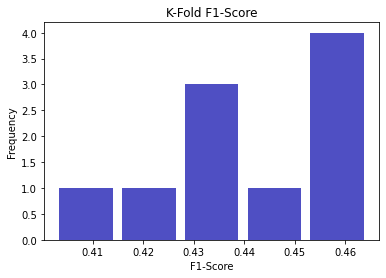

F1-Score: 0.4428771249223475 sd= 0.018939753122619824


In [44]:
# show f1-score for k-fold
res = np.array(results)
f1_score = res[:,2]
plt.hist(x=f1_score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('K-Fold F1-Score') 
plt.ylabel('Frequency') 
plt.xlabel('F1-Score') 
plt.show()
print('F1-Score:', f1_score.mean(), 'sd=', f1_score.std())

res_model1 = res
